In [1]:
if False:
    !git clone --recursive https://github.com/crowsonkb/v-diffusion-pytorch
    !pip install sample-generator
    !pip install v-diffusion-pytorch
    !pip install ipywidgets==7.7.1 gradio
    !pip install k-diffusion

In [2]:
import sys
sys.path.append('sample-generator')

#@title Imports and definitions
from prefigure.prefigure import get_all_args
from contextlib import contextmanager
from copy import deepcopy
import math
from pathlib import Path
#from google.colab import files

import os, signal, sys
import gc

from diffusion import sampling
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from tqdm import trange
from einops import rearrange

import torchaudio
from models import RecurrentScore
import numpy as np

import random
import matplotlib.pyplot as plt
import IPython.display as ipd
from audio_diffusion.utils import Stereo, PadCrop
from glob import glob



device  ="cpu"

#@title Model code
class DiffusionUncond(nn.Module):
    def __init__(self, global_args):
        super().__init__()
        self.diffusion = RecurrentScore(in_channels=128)
        self.diffusion_ema = deepcopy(self.diffusion)
        self.rng = torch.quasirandom.SobolEngine(1, scramble=True)

import matplotlib.pyplot as plt
import IPython.display as ipd

def plot_and_hear(audio, sr):
    display(ipd.Audio(audio.cpu().clamp(-1, 1), rate=sr))
    plt.plot(audio.cpu().t().numpy())
  
def load_to_device(path, sr):
    audio, file_sr = torchaudio.load(path)
    if sr != file_sr:
      audio = torchaudio.transforms.Resample(file_sr, sr)(audio)
    audio = audio.to(device)
    return audio

def get_alphas_sigmas(t):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given a timestep."""
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)

def get_crash_schedule(t):
    sigma = torch.sin(t * math.pi / 2) ** 2
    alpha = (1 - sigma ** 2) ** 0.5
    return alpha_sigma_to_t(alpha, sigma)

def t_to_alpha_sigma(t):
    """Returns the scaling factors for the clean image and for the noise, given
    a timestep."""
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)

def alpha_sigma_to_t(alpha, sigma):
    """Returns a timestep, given the scaling factors for the clean image and for
    the noise."""
    return torch.atan2(sigma, alpha) / math.pi * 2

#@title Args
sample_size = 65536 
sample_rate = 48000   
latent_dim = 0             

class Object(object):
    pass

args = Object()
args.sample_size = sample_size
args.sample_rate = sample_rate
args.latent_dim = latent_dim


# Model settings

Select the model you want to sample from
---
Model name | Description | Sample rate | Output samples
--- | --- | --- | ---
glitch-440k |Trained on clips from samples provided by [glitch.cool](https://glitch.cool) | 48000 | 65536
jmann-small-190k |Trained on clips from Jonathan Mann's [Song-A-Day](https://songaday.world/) project | 48000 | 65536
jmann-large-580k |Trained on clips from Jonathan Mann's [Song-A-Day](https://songaday.world/) project | 48000 | 131072
maestro-150k |Trained on piano clips from the [MAESTRO](https://magenta.tensorflow.org/datasets/maestro) dataset | 16000 | 65536
unlocked-250k |Trained on clips from the [Unlocked Recordings](https://archive.org/details/unlockedrecordings) dataset | 16000 | 65536
honk-140k |Trained on recordings of the Canada Goose from [xeno-canto](https://xeno-canto.org/) | 16000 | 65536


In [13]:
from urllib.parse import urlparse
import hashlib
import k_diffusion as K


custom_ckpt_path = 'dd-finetune/13mcuklp/checkpoints/epoch=17777-step=160000.ckpt'#@param {type: 'string'}

custom_sample_rate = 48000 #@param {type: 'number'}
custom_sample_size = 65536 #@param {type: 'number'}

ckpt_path = custom_ckpt_path
args.sample_size = custom_sample_size
args.sample_rate = custom_sample_rate


print("Creating the model...")
model = DiffusionUncond(args)
state_dict=torch.load(ckpt_path)["state_dict"]

print(state_dict.keys())
model.load_state_dict(state_dict, strict=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.requires_grad_(False).to(device)
print("Model created")

# # Remove non-EMA
del model.diffusion

model_fn = model.diffusion_ema




Creating the model...
odict_keys(['encodec_processor.model.encoder.model.0.conv.conv.weight', 'encodec_processor.model.encoder.model.0.conv.conv.bias', 'encodec_processor.model.encoder.model.0.conv.norm.weight', 'encodec_processor.model.encoder.model.0.conv.norm.bias', 'encodec_processor.model.encoder.model.1.block.1.conv.conv.weight', 'encodec_processor.model.encoder.model.1.block.1.conv.conv.bias', 'encodec_processor.model.encoder.model.1.block.1.conv.norm.weight', 'encodec_processor.model.encoder.model.1.block.1.conv.norm.bias', 'encodec_processor.model.encoder.model.1.block.3.conv.conv.weight', 'encodec_processor.model.encoder.model.1.block.3.conv.conv.bias', 'encodec_processor.model.encoder.model.1.block.3.conv.norm.weight', 'encodec_processor.model.encoder.model.1.block.3.conv.norm.bias', 'encodec_processor.model.encoder.model.1.shortcut.conv.conv.weight', 'encodec_processor.model.encoder.model.1.shortcut.conv.conv.bias', 'encodec_processor.model.encoder.model.1.shortcut.conv.nor

Select the sampler you want to use
---
Sampler name | Notes
--- | ---
v-iplms | This is what the model expects. Needs more steps, but more reliable.
k-heun | Needs fewer steps, but ideal sigma_min and sigma_max need to be found. Doesn't work with all models.
k-dpmpp_2s_ancestral | Fastest sampler, but you may have to find new sigmas. Recommended min & max sigmas: 0.01, 80
k-lms | "
k-dpm-2 | "
k-dpm-fast | "
k-dpm-adaptive | Takes in extra parameters for quality, step count is non-deterministic

In [4]:
#@title Sampler options
sampler_type = "v-iplms" #@param ["v-iplms", "k-heun", "k-dpmpp_2s_ancestral", "k-lms", "k-dpm-2", "k-dpm-fast", "k-dpm-adaptive"]

#@markdown ---
#@markdown **K-diffusion settings (advanced)**
sigma_min = 0.0001 #@param {type: "number"}
sigma_max = 1 #@param {type: "number"}
rho=7. #@param {type: "number"}
#@markdown k-dpm-adaptive settings
rtol = 0.01 #@param {type: "number"}
atol = 0.01 #@param {type: "number"}

def sample(in_model_fn,noise,text_embedding,steps=100, sampler_type="v-iplms", noise_level = 1.0):
  def model_fn(x,t):
    return in_model_fn(x,t, text_embedding)

  #Check for k-diffusion
  if sampler_type.startswith('k-'):
    denoiser = K.external.VDenoiser(model_fn)
    sigmas = K.sampling.get_sigmas_karras(steps, sigma_min, sigma_max, rho, device=device)

  if sampler_type == "v-iplms":
    t = torch.linspace(1, 0, steps + 1, device=device)[:-1]
    step_list = get_crash_schedule(t)

    return sampling.iplms_sample(model_fn, noise, step_list, {})

  elif sampler_type == "k-heun":
    return K.sampling.sample_heun(denoiser, noise, sigmas, disable=False)
  elif sampler_type == "k-lms":
    return K.sampling.sample_lms(denoiser, noise, sigmas, disable=False)
  elif sampler_type == "k-dpmpp_2s_ancestral":
    return K.sampling.sample_dpmpp_2s_ancestral(denoiser, noise, sigmas, disable=False)
  elif sampler_type == "k-dpm-2":
    return K.sampling.sample_dpm_2(denoiser, noise, sigmas, disable=False)
  elif sampler_type == "k-dpm-fast":
    return K.sampling.sample_dpm_fast(denoiser, noise, sigma_min, sigma_max, steps, disable=False)
  elif sampler_type == "k-dpm-adaptive":
    return K.sampling.sample_dpm_adaptive(denoiser, noise, sigma_min, sigma_max, rtol=rtol, atol=atol, disable=False)

def resample(in_model_fn, audio, text_embedding,steps=100, sampler_type="v-iplms", noise_level = 1.0):
  def model_fn(x,t):
    return in_model_fn(x,t, text_embedding)
  #Noise the input
  if sampler_type == "v-iplms":
    t = torch.linspace(0, 1, steps + 1, device=device)
    step_list = get_crash_schedule(t)
    step_list = step_list[step_list < noise_level]

    alpha, sigma = t_to_alpha_sigma(step_list[-1])
    noised = torch.randn([batch_size, 2, effective_length], device='cuda')
    noised = audio * alpha + noised * sigma

  elif sampler_type.startswith("k-"):
    denoiser = K.external.VDenoiser(model_fn)
    noised = audio + torch.randn_like(audio) * noise_level
    sigmas = K.sampling.get_sigmas_karras(steps, sigma_min, noise_level, rho, device=device)

  # Denoise
  if sampler_type == "v-iplms":
    return sampling.iplms_sample(model_fn, noised, step_list.flip(0)[:-1], {})

  elif sampler_type == "k-heun":
    return K.sampling.sample_heun(denoiser, noised, sigmas, disable=False)

  elif sampler_type == "k-dpmpp_2s_ancestral":
    return K.sampling.sample_dpmpp_2s_ancestral(denoiser, noised, sigmas, disable=False)

  elif sampler_type == "k-lms":
    return K.sampling.sample_lms(denoiser, noised, sigmas, disable=False)

  elif sampler_type == "k-dpm-2":
    return K.sampling.sample_dpm_2(denoiser, noised, sigmas, s_noise=0., disable=False)

  elif sampler_type == "k-dpm-fast":
    return K.sampling.sample_dpm_fast(denoiser, noised, sigma_min, noise_level, steps, disable=False)

  elif sampler_type == "k-dpm-adaptive":
    return K.sampling.sample_dpm_adaptive(denoiser, noised, sigma_min, noise_level, rtol=rtol, atol=atol, disable=False)

def reverse_sample(in_model_fn, audio, text_embedding,steps=100, sampler_type="v-iplms", noise_level = 1.0):
  def model_fn(x,t):
    return in_model_fn(x,t, text_embedding)
  if sampler_type == "v-iplms":
    t = torch.linspace(0, 1, steps + 1, device=device)
    step_list = get_crash_schedule(t)

    return sampling.iplms_sample(model_fn, audio, step_list, {}, is_reverse=True)

  elif sampler_type.startswith("k-"):
    denoiser = K.external.VDenoiser(model_fn)
    sigmas = K.sampling.get_sigmas_karras(steps, sigma_min, noise_level, rho, device=device)

  # Denoise
  if sampler_type == "k-heun":
    return K.sampling.sample_heun(denoiser, audio, sigmas.flip(0)[:-1], disable=False)
  elif sampler_type == "k-lms":
    return K.sampling.sample_lms(denoiser, audio, sigmas.flip(0)[:-1], disable=False)
  elif sampler_type == "k-dpmpp_2s_ancestral":
    return K.sampling.sample_dpmpp_2s_ancestral(denoiser, audio, sigmas.flip(0)[:-1], disable=False)
  elif sampler_type == "k-dpm-2":
    return K.sampling.sample_dpm_2(denoiser, audio, sigmas.flip(0)[:-1], s_noise=0., disable=False)
  elif sampler_type == "k-dpm-fast":
    return K.sampling.sample_dpm_fast(denoiser, audio, noise_level, sigma_min, steps, disable=False)

  elif sampler_type == "k-dpm-adaptive":
    return K.sampling.sample_dpm_adaptive(denoiser, audio, noise_level, sigma_min, rtol=rtol, atol=atol, disable=False)

# Generate new sounds

Feeding white noise into the model to be denoised creates novel sounds in the "space" of the training data.

  0%|          | 0/200 [00:00<?, ?it/s]

torch.Size([1, 128, 150])
torch.Size([2, 48000])


sample #1


sample #2


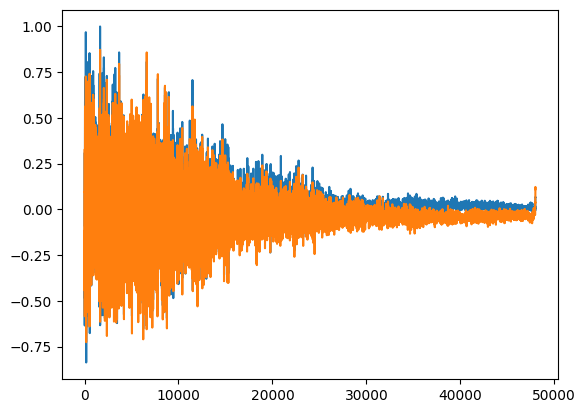

In [16]:
from encodec_processor import EncodecProcessor
from text_embedder import TextEmbedder
#@markdown How many audio clips to create
batch_size =  100#@param {type:"number"}

#@markdown Number of steps (100 is a good start, more steps trades off speed for quality)
steps = 200 #@param {type:"number"}

#@markdown Check the box below to skip this section when running all cells
skip_for_run_all = False #@param {type: "boolean"}

N_TIMESTEPS=150
N_CHANNELS=128

text="Crash"
text_embedder = TextEmbedder()
text_embedding = text_embedder.embed_text(text).to(device)[None,:].repeat(batch_size,1)
encodec_processor = EncodecProcessor(48000).to(device)

def sonify(fakes):
        embeddings = fakes

        # decode here
        fakes = encodec_processor.decode_embeddings(embeddings)

        # Put the demos together
        fakes = rearrange(fakes, "b d n -> d (b n)")
        fakes = fakes / torch.max(torch.abs(fakes) + 1e-8)
        return fakes
if not skip_for_run_all:
  torch.cuda.empty_cache()
  gc.collect()

  # Generate random noise to sample from
  noise = torch.randn([batch_size, N_CHANNELS, N_TIMESTEPS]).to(device)
  generated = sample(model_fn, noise, text_embedding, steps, sampler_type)


  print(generated.shape)
  generated = sonify(generated)
  generated = generated.cpu().detach()

  print(generated.shape)
  # # Hard-clip the generated audio
  generated_all = generated.clamp(-1, 1)

  # Put the demos together

  plot_and_hear(generated_all, args.sample_rate)
  for ix, gen_sample in enumerate(generated):
    print(f'sample #{ix + 1}')
    display(ipd.Audio(gen_sample.cpu(), rate=args.sample_rate))


else:
  print("Skipping section, uncheck 'skip_for_run_all' to enable")


# Regenerate your own sounds
By adding noise to an audio file and running it through the model to be denoised, new details will be created, pulling the audio closer to the "sonic space" of the model. The more noise you add, the more the sound will change.

The effect of this is a kind of "style transfer" on the audio. For those familiar with image generation models, this is analogous to an "init image".

In [ ]:
#@title Record audio or enter a filepath to a prerecorded audio file
import torch
import torchaudio
from typing import Iterable, Tuple

Audio = Tuple[int, np.ndarray]

#@markdown Check the box below to create an audio recording interface below
record_audio = True #@param {type: "boolean"}

#@markdown If you left "record_audio" blank, enter a path to an audio file you want to alter, or leave blank to upload a file (.wav or .flac).
file_path = "" #@param{type:"string"}

#@markdown Number of audio recordings to combine into one clip. Only applies if the "record_audio" box is checked.
n_audio_recordings = 1 #@param{type:"number"}

# this is a global variable to be filled in by the generate_from_audio callback
recording_file_path = ""


def combine_audio(*audio_iterable: Iterable[Audio]) -> Audio:
    """Combines an iterable of audio signals into one."""
    max_len = max([x.shape for _, x in audio_iterable])
    combined_audio = np.zeros(max_len, dtype=np.int32)
    for _, a in audio_iterable:
        combined_audio[:a.shape[0]] = combined_audio[:a.shape[0]] * .5 + a * .5
    return combined_audio


def generate_from_audio(file_path: str, *audio_iterable: Iterable[Audio]):
    sample_rate = audio_iterable[0][0]
    combined_audio = combine_audio(*audio_iterable)
    tensor = torch.from_numpy(
        np.concatenate(
            [
                combined_audio.reshape(1, -1),
                combined_audio.reshape(1, -1)
            ],
            axis=0,
        )
    )
    global recording_file_path
    recording_file_path = file_path
    torchaudio.save(
        file_path,
        tensor,
        sample_rate=sample_rate,
        format="wav"
    )
    return (sample_rate, combined_audio), file_path

if record_audio:
    recording_interface = gr.Interface(
        fn=generate_from_audio,
        inputs=[
            gr.Textbox(
                "/content/recording.wav",
                label="save recording to filepath",
            ),
            *[
                gr.Audio(source="microphone", label=f"audio clip {i}")
                for i in range(1, n_audio_recordings + 1)
            ]
        ],
        outputs=[
            gr.Audio(label="combined output audio"),
            gr.File(label="output file"),
        ],
        allow_flagging="never",
    )

    recording_interface.launch();
elif file_path == "":
    print("No file path provided, please upload a file")
    # uploaded = files.upload()
    file_path = list(uploaded.keys())[0]

if not record_audio:
    print(f"Using file_path: {file_path} to regenerate new sounds.")

In [ ]:
#@title Generate new sounds from recording

#@markdown Total number of steps (100 is a good start, more steps trades off speed for quality)
steps = 100#@param {type:"number"}

#@markdown How much (0-1) to re-noise the original sample. Adding more noise (a higher number) means a bigger change to the input audio
noise_level = 0.3#@param {type:"number"}

#@markdown Multiplier on the default sample length from the model, allows for longer audio clips at the expense of VRAM
sample_length_mult = 2#@param {type:"number"}

#@markdown How many variations to create
batch_size = 4 #@param {type:"number"}

#@markdown Check the box below to save your generated audio to [Weights & Biases](https://www.wandb.ai/site)
save_own_generations_to_wandb = False #@param {type: "boolean"}

#@markdown Check the box below to skip this section when running all cells
skip_for_run_all = False #@param {type: "boolean"}

effective_length = args.sample_size * sample_length_mult

if not skip_for_run_all:
  torch.cuda.empty_cache()
  gc.collect()

  augs = torch.nn.Sequential(
    PadCrop(effective_length, randomize=True),
    Stereo()
  )

  fp = recording_file_path if record_audio else file_path

  audio_sample = load_to_device(fp, args.sample_rate)

  audio_sample = augs(audio_sample).unsqueeze(0).repeat([batch_size, 1, 1])

  print("Initial audio sample")
  plot_and_hear(audio_sample[0], args.sample_rate)
  
  generated = resample(model_fn, audio_sample, steps, sampler_type, noise_level=noise_level)

  print("Regenerated audio samples")
  plot_and_hear(rearrange(generated, 'b d n -> d (b n)'), args.sample_rate)

  for ix, gen_sample in enumerate(generated):
    print(f'sample #{ix + 1}')
    display(ipd.Audio(gen_sample.cpu(), rate=args.sample_rate))

else:
  print("Skipping section, uncheck 'skip_for_run_all' to enable")

# Interpolate between sounds
Diffusion models allow for interpolation between inputs through a process of deterministic noising and denoising. 

By deterministically noising two audio files, interpolating between the results, and deterministically denoising them, we can can create new sounds "between" the audio files provided.

In [ ]:
# Interpolation code taken and modified from CRASH
def compute_interpolation_in_latent(latent1, latent2, lambd):
    '''
    Implementation of Spherical Linear Interpolation: https://en.wikipedia.org/wiki/Slerp
    latent1: tensor of shape (2, n)
    latent2: tensor of shape (2, n)
    lambd: list of floats between 0 and 1 representing the parameter t of the Slerp
    '''
    device = latent1.device
    lambd = torch.tensor(lambd)

    assert(latent1.shape[0] == latent2.shape[0])

    # get the number of channels
    nc = latent1.shape[0]
    interps = []
    for channel in range(nc):
    
      cos_omega = latent1[channel]@latent2[channel] / \
          (torch.linalg.norm(latent1[channel])*torch.linalg.norm(latent2[channel]))
      omega = torch.arccos(cos_omega).item()

      a = torch.sin((1-lambd)*omega) / np.sin(omega)
      b = torch.sin(lambd*omega) / np.sin(omega)
      a = a.unsqueeze(1).to(device)
      b = b.unsqueeze(1).to(device)
      interps.append(a * latent1[channel] + b * latent2[channel])
    return rearrange(torch.cat(interps), "(c b) n -> b c n", c=nc) 

#@markdown Enter the paths to two audio files to interpolate between (.wav or .flac)
source_audio_path = "" #@param{type:"string"}
target_audio_path = "" #@param{type:"string"}

#@markdown Total number of steps (100 is a good start, can go lower for more speed/less quality)
steps = 100#@param {type:"number"}

#@markdown Number of interpolated samples
n_interps = 12 #@param {type:"number"}

#@markdown Multiplier on the default sample length from the model, allows for longer audio clips at the expense of VRAM
sample_length_mult = 1#@param {type:"number"}

#@markdown Check the box below to skip this section when running all cells
skip_for_run_all = False #@param {type: "boolean"}

effective_length = args.sample_size * sample_length_mult

if not skip_for_run_all:

  augs = torch.nn.Sequential(
    PadCrop(effective_length, randomize=True),
    Stereo()
  )

  if source_audio_path == "":
    print("No file path provided for the source audio, please upload a file")
    uploaded = files.upload()
    source_audio_path = list(uploaded.keys())[0]

  audio_sample_1 = load_to_device(source_audio_path, args.sample_rate)

  print("Source audio sample loaded")

  if target_audio_path == "":
    print("No file path provided for the target audio, please upload a file")
    uploaded = files.upload()
    target_audio_path = list(uploaded.keys())[0]

  audio_sample_2 = load_to_device(target_audio_path, args.sample_rate)

  print("Target audio sample loaded")

  audio_samples = augs(audio_sample_1).unsqueeze(0).repeat([2, 1, 1])
  audio_samples[1] = augs(audio_sample_2)

  print("Initial audio samples")
  plot_and_hear(audio_samples[0], args.sample_rate)
  plot_and_hear(audio_samples[1], args.sample_rate)

  reversed = reverse_sample(model_fn, audio_samples, steps)

  latent_series = compute_interpolation_in_latent(reversed[0], reversed[1], [k/n_interps for k in range(n_interps + 2)])

  generated = sample(model_fn, latent_series, steps) 
  
  #sampling.iplms_sample(, latent_series, step_list.flip(0)[:-1], {})

  # Put the demos together
  generated_all = rearrange(generated, 'b d n -> d (b n)')

  print("Full interpolation")
  plot_and_hear(generated_all, args.sample_rate)
  for ix, gen_sample in enumerate(generated):
    print(f'sample #{ix + 1}')
    display(ipd.Audio(gen_sample.cpu(), rate=args.sample_rate))
else:
  print("Skipping section, uncheck 'skip_for_run_all' to enable") 